In [2]:
!pip install Selenium

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [3]:
import pandas as pd

In [4]:
driver = webdriver.Chrome()

In [5]:
driver.get("https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm")

In [6]:
###En esta celda se realiza el proceso de recolección de la API a través de Selenium y del Xpath de la página web
headers = ["Borough", "region", "Males", "Females", "Total Population"]
data = []
for j in range(1, 56):
    union=[]
    th=[]
    td=[]
    if j <= 10:
        th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{1}]/th[1]").text)
    if j >= 11 and j < 29:
        th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{11}]/th[1]").text)
    if j >= 29 and j < 39:
        th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{29}]/th[1]").text)
    if j >= 39 and j < 53:
        th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{39}]/th[1]").text)
    if j >= 53:
        th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{53}]/th[1]").text)
    for i in range(1, 4):
        if i != 3:
            if i != 1:
                th.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{j}]/th[{i}]").text)
            td.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{j}]/td[{i}]").text)
        else:
            td.append(driver.find_element(By.XPATH,f"/html/body/div[2]/div/div[2]/table/tbody/tr[{j}]/td[{i}]").text)
            union=th+td
            data.append(union)
dfBono = pd.DataFrame(data, columns=headers)

In [7]:
dfBono.head()


,Borough,region,Males,Females,Total Population
0,Bronx,"Riverdale, Fieldston & Kingsbridge","52,133","61,937","114,070"
1,Bronx,"Wakefield, Williamsbridge & Woodlawn","65,087","77,848","142,935"
2,Bronx,"Co-op City, Pelham Bay & Schuylerville","55,615","65,929","121,544"
3,Bronx,"Pelham Parkway, Morris Park & Laconia","61,233","67,896","129,130"
4,Bronx,"Belmont, Crotona Park East & East Tremont","75,963","87,740","163,704"


In [8]:
###La idea de esta celda es actualizar los nombres del dataframe que se tiene del web scrapping para que los nombres de los distritos de nueva york sea igual tanto en el df como en GeoJSON que ayudará a graficar
nombre_mapper = {
    'Richmond (Staten Island)': 'Staten Island',
    'New York (Manhattan)': 'Manhattan',
    'Kings (Brooklyn)': 'Brooklyn'
}

dfBono['Borough'] = dfBono['Borough'].replace(nombre_mapper)

In [9]:
###Debido al formato de la tabla de la página web se tuvo que cambiar los valores de los atributos que son numéricos ya que al contener "," se identifica como un string y se tuvo que quitar para poder operar con ellos
dfBono['Males'] = dfBono['Males'].str.replace(',', '').astype(float)
dfBono['Females'] = dfBono['Females'].str.replace(',', '').astype(float)

# Sumar las columnas 'Males' y 'Females' para obtener 'Total Population'
dfBono['Total Population'] = dfBono['Males'] + dfBono['Females']

# Ahora realiza la suma de población por 'Borough'
df_suma_poblacion = dfBono.groupby('Borough')['Total Population'].sum().reset_index()

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify

###Se usa el enlace al GeoJSON que se encuentra en el repositorio de GitHub y de ahí extraer las formas geométricas de los distritos de nueva york
url = 'https://raw.githubusercontent.com/TommyDS2005/Proyecto-Procesamiento-de-Datos/main/new-york-city-boroughs.geojson'
gdf = gpd.read_file(url)

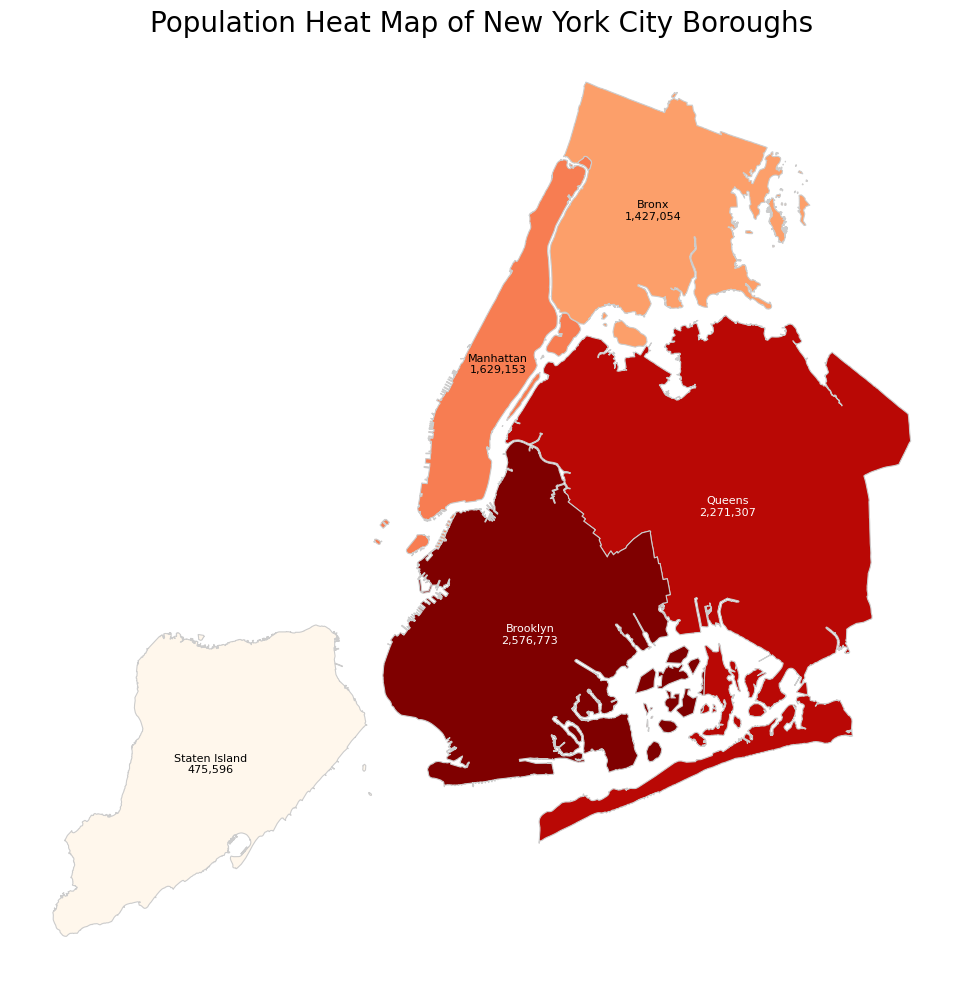

In [11]:
###Se Juntan en un solo dataset los atributos de df_suma_poblacion y de gdf para que se tenga en una sola tabla los atributos de población y de forma geométrica, es como un Join
gdf_merge = gdf.merge(df_suma_poblacion, left_on='name', right_on='Borough')

gdf_merge['Total Population'] = pd.to_numeric(gdf_merge['Total Population'], errors='coerce')

# Crear etiquetas con el nombre del distrito y la población total
gdf_merge['label'] = gdf_merge.apply(lambda x: f"{x['Borough']}\n{int(x['Total Population']):,}", axis=1)

# Graficar el GeoDataFrame con la columna 'Total Population'
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_merge.plot(column='Total Population', cmap='OrRd', linewidth=0.8, edgecolor='0.8', ax=ax)
# Añadir las etiquetas a la figura
for idx, row in gdf_merge.iterrows():
    # El color del texto depende de la luminosidad del color del fondo
    # Utilizamos una simple estimación de la luminosidad para decidir el color del texto
    # basado en la población total (esto podría no ser exacto y es una simplificación)
    if row['Total Population'] > 2200000:
        text_color = 'white'
    else:
        text_color = 'black'
    
    plt.annotate(text=row['label'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 ha='center', va='center', fontsize=8, color = text_color)

# Ajustar la posición del título
ax.set_title('Population Heat Map of New York City Boroughs', fontdict={'fontsize': 20}, loc='center')

# Desactivar los ejes
ax.set_axis_off()

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()